In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
train_data = pd.read_csv("poverty/src/data/train.csv")

# Impute Missing Value

According to the following table, we know that variables rez_esc, v18q1, v2a1, SQBmeaned, and meaneduc contain missing value. <br>
<br>
**rez_esc**: Years behind in school<br>
**v18q1**: number of tablets household owns<br>
**v2a1**: Monthly rent payment<br>
**SQBmeaned**: square of the mean years of education of adults (>=18) in the household<br>
**meaneduc**: average years of education for adults (18+)<br>

In [3]:
# Number of missing in each column
missing = pd.DataFrame(train_data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train_data)

missing.sort_values('percent', ascending = False).head(7)

,total,percent
rez_esc,7928,0.829549
v18q1,7342,0.768233
v2a1,6860,0.717798
SQBmeaned,5,0.000523
meaneduc,5,0.000523
instlevel2,0,0.000000
instlevel1,0,0.000000


## 1. rez_esc

`rez_esc` indicates years behind in school. Since the percentage of missing value is more than 80%, it will be hard to predict the missing value and the predicted value may be inaccuate. Therefore, we choose to drop this column. 

In [4]:
null_rez = train_data['rez_esc'].isnull()

In [5]:
print('The row with missing value: ' + str(sum(null_rez) / len(null_rez)))

The row with missing value: 0.8295490216595166


In [6]:
train_data = train_data.drop("rez_esc", axis = 1)

## 2. v18q1

In the dataset, we know that `v18q` indicates whether or not a family owns a tablet, where 0 indicates no tablet and 1 indicates own tablet. When we check v18q and v18q1, we find that when column v18q shows 0, there is a missing value in column v18q1. Then, we suppose that families with a NaN in this category just do not own a tablet. 

In [7]:
train_data[['v18q','v18q1']].head()

,v18q,v18q1
0,0,NaN
1,1,1.0
2,0,NaN
3,1,1.0
4,1,1.0


We choose to groupby the value of v18q (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for v18q1. This will tell us if the null values represent that the family does not own a tablet.

In [8]:
null_df = train_data.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum()).to_frame(name=None)
null_df.columns = ['num']
null_df

,num
v18q,
0,7342
1,0


Therefore, according to the result above, we know that family with NaN in v18q1 means that the family does not own a tablet. To be more specific, we can fill in the missing value with value 0. 

In [9]:
train_data['v18q1'] = train_data['v18q1'].fillna(0)

## 3. v2a1

`v2a1` represents monthly rent payment. <br>
In order to impute the missing values of the monthly rent payment, we also check the relationship between v2a1 and tipovivi which represent the ownership or renting status of the home. <br>
For this plot, we show the ownership status of those homes with a nan for the monthyl rent payment.

In [10]:
data_with_null_v2a1 = train_data.loc[train_data['v2a1'].isnull()]

In [11]:
own_variables = [x for x in data_with_null_v2a1 if x.startswith('tipo')]

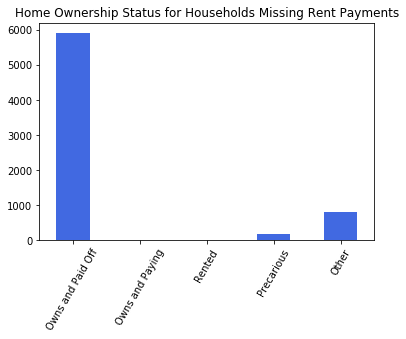

In [12]:
data_with_null_v2a1[own_variables].sum().plot.bar(color = 'royalblue');
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments');

We can find that most of family with the missing value in v2a1 "owns and paid off" their house so they do not have to pay the rent. For "Precarious" and "Other", for any reason, the families do not need to pay for the rent as well. <br>
Therefore, we will impute the missing value with value 0 in this column. 

In [13]:
train_data['v2a1'] = train_data['v2a1'].fillna(0)

## 4. SQBmeaned & meaneduc

We know that SQBmeaned is square of the meaneduc and there are only 5 rows of missing value. We choose to drop these 5 rows of data.

In [14]:
train_data = train_data.dropna()

## Save Data as .csv File

Convert `idhogar` to dummy variables

In [15]:
# train_data = pd.get_dummies(train_data)

In [16]:
train_data.to_csv("poverty/src/data/poverty_data_with_dummy.csv", index=False)